In [1]:
import numpy as np
import cv2
import tree2
import karol
import os
import matplotlib
import matplotlib.pyplot as plt
import ete2
from group_nodes_2_text import *

%matplotlib inline

def show(img, cvt=cv2.COLOR_GRAY2RGB, do_cvt=True):
    plt.figure(figsize=(10,10))
    if do_cvt:
        plt.imshow(cv2.cvtColor(img, cvt))
    else:
        plt.imshow(img)


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 29 days


In [2]:
reload(tree2)
reload(karol)

<module 'karol' from 'karol.pyc'>

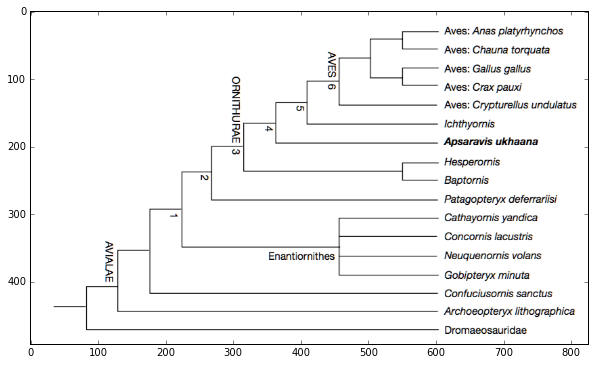

In [3]:
images = [os.path.join("images", f) for f in os.listdir("images")]
fn = "images/tree_image_ref.png"
# print images
show(cv2.imread(fn), False)

In [4]:
img = cv2.imread(fn)
scratch = img.copy()
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
corners = karol.get_contour(img, gray)
nodes = karol.nodes_from_corners(img, gray, corners, max_dist=8, iterations=3)
node_neighbors = karol.node_neighbors(nodes, gray)
karol.unhook_triangles(nodes, node_neighbors)
root = karol.find_root(nodes, node_neighbors)
sources = karol.depth_first_cycle_finder(np.copy(img), nodes, node_neighbors, root)
while sources is None:
    sources = karol.depth_first_cycle_finder(np.copy(img), nodes, node_neighbors, root)

for i in range(len(nodes)):
    if len(node_neighbors[i]) == 2:
        n1, n2 = node_neighbors[i]
        for j in node_neighbors:
            #print(node_neighbors[j], i, j)
            node_neighbors[j] = [x for x in node_neighbors[j] if x != i]
        node_neighbors[n1].append(n2)
        node_neighbors[n2].append(n1)
        del node_neighbors[i]
    
for i in sorted(node_neighbors):
    node_x, node_y = nodes[i]
    for neighbor in node_neighbors[i]:
        neighbor_x, neighbor_y = nodes[neighbor]
        cv2.line(scratch, (node_x, node_y), (neighbor_x, neighbor_y), (0,255,0), 3)
        
for i in sorted(node_neighbors):
    cv2.putText(scratch, str(i), nodes[i], cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))


In [5]:
def labels_for_tree(just_tree, nodes):
    # just_tree = cv2.imread(image_path) #use k=9 to get only tips, k=4 gets some of the labels but is not as clean
    result = label_rectangles(just_tree)
    labels = [(pos, get_label(Image.fromarray(just_tree), pos) ) for pos in result[1] ]
    associations = []
    for label in labels:
        r,lname = label
        x,y,w,h = r
        # get distances to all nodes
        distances = set()
        for node in nodes:
            x1,y1 = node
            d = distance.euclidean((x,y),node)
            distances.add((d,node))
        #get the node that is the minimum distance and name it
        associations.append((min(distances)[1],(x,y),lname))
    tree = result[0].copy()
    return associations

def get_label(img, pos):
    x,y,w,h = pos
#     img = Image.fromarray(img)
    box = (x, y, x + w, y + h)
    ocr_ready = img.crop(box)
    return imgToStr(np.asarray(ocr_ready))

def imgToStr(im):
#     type(im)
    gray_im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    gray_image = Image.fromarray(gray_im)
    str = pytesseract.image_to_string(gray_image, config="--tessedit_char_whitelist AaBbCcDdEeFfGgHhIiJjKkLlMmNnOoPpQqRrSsTtUuVvWwXxYyZz_0123456789")

    return str

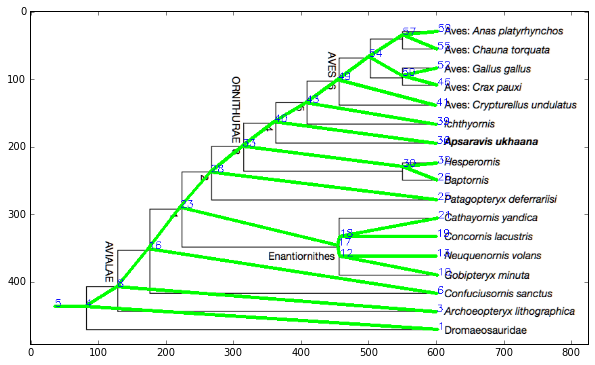

In [6]:
neighbors = {nodes[k] : [nodes[w] for w in v] for k,v in node_neighbors.iteritems()}
edges = tree2.get_edges(neighbors, root=root)
    
all_points = set([p for e in edges for p in e])
# print all_points
# print nodes

labels = labels_for_tree(cv2.imread(fn), all_points)

label_dict = {p:None for p in all_points}
for label in labels:
    if label[0] and label[0] in tree2.get_leafs(edges):
        label_dict[label[0]] = label[2]
        
tree = tree2.build_tree(edges, label_dict)
show(scratch, False)

In [7]:
tree_str = str(tree).replace(", ", ",").replace(" ", "_").replace("'","").replace(":","")
print tree_str
tree_obj = ete2.Tree("{};".format(tree_str), format=1)
print tree_obj

((Apsaravis_ukhaana,(lchthyomls,(Aves_Crypmrenus_undu/ams,((Aves_Ana_platymynchos,Aves_Chauna_torquata),(Aves_Gallus_gallus,Aves_Clax_pauxl))))),(((Confuciusomls_sancms,(((36,436),Dmmaeosaundae),Archaeopteryx_Immgraphrca)),((Neuquenorrus_Volans,Gobrpteryx_mmura),(Concomrs_Iacusms,Camayomrs_yandrca))),Patagopteryx_deferrams),(Bapmrms,Hespemmls))

      /-Apsaravis_ukhaana
     |
   /-|   /-lchthyomls
  |  |  |
  |   \-|   /-Aves_Crypmrenus_undu/ams
  |     |  |
  |      \-|      /-Aves_Ana_platymynchos
  |        |   /-|
  |        |  |   \-Aves_Chauna_torquata
  |         \-|
  |           |   /-Aves_Gallus_gallus
  |            \-|
  |               \-Aves_Clax_pauxl
  |
  |         /-Confuciusomls_sancms
  |        |
  |        |         /-36
  |      /-|      /-|
--|     |  |   /-|   \-436
  |     |  |  |  |
  |     |   \-|   \-Dmmaeosaundae
  |     |     |
  |   /-|      \-Archaeopteryx_Immgraphrca
  |  |  |
  |  |  |      /-Neuquenorrus_Volans
  |  |  |   /-|
  |  |  |  |   \-Gobr